In [1]:
import torch
from torch.autograd import Function, Variable
import torch.nn.functional as F
from torch import nn
from torch.nn.parameter import Parameter
import torch.optim as optim
from torch.nn.utils import parameters_to_vector
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import numpy.random as npr

import matplotlib
from matplotlib import pyplot as plt

from mpc import mpc
from mpc.mpc import GradMethods, QuadCost, LinDx
from mpc import casadi_control
#from mpc.dynamics import NNDynamics
#import mpc.util as eutil
from mpc.env_dx import frenet_dyn_bicycle, frenet_kin_bicycle  #changed
from mpc.track.src import simple_track_generator, track_functions

import time
import os
import shutil
import pickle as pkl
import collections

import argparse





class NN(nn.Module):
    #changed output dimensions
    def __init__(self, H, S, O):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(H + S, 128)  
        self.fc2 = nn.Linear(128, 128)  
        self.output1 = nn.Linear(128, O) 
        self.output2 = nn.Linear(128, O) 

    def forward(self, c, x0):
        combined = torch.cat((c, x0), dim=1)
        x = F.relu(self.fc1(combined))
        x = F.relu(self.fc2(x))
        q = F.relu(self.output1(x)) + 0.0001
        p = self.output2(x)
        return q, p
    
def penalty_d(d, th, factor=10000):  
    overshoot_pos = (d - th).clamp(min=0)
    overshoot_neg = (-d - th).clamp(min=0)
    penalty_pos = torch.exp(overshoot_pos) - 1
    penalty_neg = torch.exp(overshoot_neg) - 1 
    return factor*(penalty_pos + penalty_neg)

def penalty_v(v, th, factor=10000): 
    overshoot_pos = (v - th).clamp(min=0)
    overshoot_neg = (-v + 0.001).clamp(min=0)
    penalty_pos = torch.exp(overshoot_pos) - 1
    penalty_neg = torch.exp(overshoot_neg) - 1 
    return factor*(penalty_pos + penalty_neg)



# Let's try to create a track 
track_density = 300
track_width = 0.5




gen = simple_track_generator.trackGenerator(track_density,track_width)
track_name = 'LONG_TRACK'

t = 0.3
init = [0,0,0]

track_function = {
    'DEMO_TRACK'    : track_functions.demo_track,
    'HARD_TRACK'    : track_functions.hard_track,
    'LONG_TRACK'    : track_functions.long_track,
    'LUCERNE_TRACK' : track_functions.lucerne_track,
    'BERN_TRACK'    : track_functions.bern_track,
    'INFINITY_TRACK': track_functions.infinity_track,
    'SNAIL_TRACK'   : track_functions.snail_track
}.get(track_name, track_functions.demo_track)
    
track_function(gen, t, init)
    
gen.populatePointsAndArcLength()
gen.centerTrack()

track_coord = torch.from_numpy(np.vstack([gen.xCoords, gen.yCoords, gen.arcLength, gen.tangentAngle, gen.curvature]))

device = 'cpu' #to do




mpc_T = 20
H_curve = 60

n_batch = 16


l_r = 0.2
l_f = 0.2

v_max = 2.5
a_max = 3.
delta_max = 0.4 # taken from hardware

# not using
ac_max = (0.7*v_max)**2 * delta_max / (l_r+l_f)

dt = 0.04

params = torch.tensor([l_r, l_f, track_width, v_max, ac_max, dt, a_max, delta_max])

true_dx = frenet_kin_bicycle.FrenetKinBicycleDx(track_coord, params)
true_sim_dx = frenet_kin_bicycle.FrenetKinBicycleDx(track_coord, params)
#true_sim_dx = frenet_dyn_bicycle.FrenetDynBicycleDx(track_coord, params)

u_lower = torch.tensor([-a_max, -delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1)
u_upper = torch.tensor([a_max, delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1)
u_init= torch.tensor([0.1, 0.0]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1)

n_state = true_dx.n_state
n_ctrl = true_dx.n_ctrl

eps = .1
lqr_iter = 30
grad_method = GradMethods.AUTO_DIFF

#softplus_op = torch.nn.Softplus(10)

def sample_xinit(n_batch):
    def uniform(shape, low, high):
        r = high-low
        return torch.rand(shape)*r+low
    sigma = uniform(n_batch, 0.01, 20.)
    d = uniform(n_batch, -track_width*0.35, track_width*0.35)
    phi = uniform(n_batch, -0.4*np.pi, 0.4*np.pi)
    #r = uniform(n_batch, -0.05*np.pi, 0.05*np.pi)
    v = uniform(n_batch, .01, 0.95*v_max)
    #v_y = uniform(n_batch, 0., 0.05)

    sigma_0 = sigma
    sigma_diff = sigma-sigma_0
    
    d_pen = penalty_d(d, 0.4*track_width)
    v_ub = penalty_v(v, v_max)
    
    k = true_dx.curv(sigma)

    xinit = torch.stack((sigma, d, phi, v, sigma_0, sigma_diff, d_pen, v_ub), dim=1)
    return xinit


def sample_xinit_paj(n_batch):
    def uniform(shape, low, high):
        r = high-low
        return torch.rand(shape)*r+low
    sigma = uniform(n_batch, 0.01, 20.)
    d = uniform(n_batch, -track_width*0.4, track_width*0.4)
    phi = uniform(n_batch, -0.4*np.pi, 0.4*np.pi)
    r = uniform(n_batch, -0.05*np.pi, 0.05*np.pi)
    v_x = uniform(n_batch, 1., v_max)
    v_y = uniform(n_batch, 0., 0.05)

    sigma_0 = sigma
    sigma_diff = sigma-sigma_0
    
    d_pen = penalty_d(d, 0.4*track_width)
    v_ub = penalty_v(v_x, v_max)
    
    k = true_dx.curv(sigma)

    xinit = torch.stack((sigma, d, phi, r, v_x, v_y, sigma_0, sigma_diff, d_pen, v_ub), dim=1)
    return xinit


def fixed_sample_xinit(n_batch, seed):
    torch.manual_seed(seed)
    def uniform(shape, low, high):
        r = high-low
        return torch.rand(shape)*r+low
    sigma = uniform(n_batch, 0.01, 20.)
    d = uniform(n_batch, -track_width*0.3, track_width*0.3)
    phi = uniform(n_batch, -0.4*np.pi, 0.4*np.pi)
    r = uniform(n_batch, -0.05*np.pi, 0.05*np.pi)
    v_x = uniform(n_batch, 1., v_max)
    v_y = uniform(n_batch, 0., 0.05)

    sigma_0 = sigma
    sigma_diff = sigma-sigma_0
    
    d_pen = penalty_d(d, 0.4*track_width)
    v_ub = penalty_v(v_x, v_max)
    
    k = true_dx.curv(sigma)

    xinit = torch.stack((sigma, d, phi, r, v_x, v_y, sigma_0, sigma_diff, d_pen, v_ub), dim=1)
    return xinit


def get_nearest_index(point_f, ref_path):
    return ((point_f[0] - ref_path[2,:])**2).argmin()
    
def compute_x_coord(point_f, ref_path, nearest_index):
    return ref_path[0,nearest_index] - point_f[1]*torch.sin(ref_path[3,nearest_index])

def compute_y_coord(point_f, ref_path, nearest_index):
    return ref_path[1,nearest_index] + point_f[1]*torch.cos(ref_path[3,nearest_index])

def frenet_to_cartesian(point_f, ref_path):     
    nearest_index = get_nearest_index(point_f, ref_path)
    x = compute_x_coord(point_f, ref_path, nearest_index)
    y = compute_y_coord(point_f, ref_path, nearest_index)
    
    return torch.tensor([x, y])



def get_loss_progress(x_init, dx, _Q, _p, mpc_T=mpc_T):    
        
        pred_x, pred_u, pred_objs = mpc.MPC(
            dx.n_state, dx.n_ctrl, mpc_T,
            u_lower=u_lower, u_upper=u_upper, u_init=u_init,
            lqr_iter=lqr_iter,
            verbose=1,
            exit_unconverged=False,
            detach_unconverged=False,
            linesearch_decay=.8,
            max_linesearch_iter=10,
            grad_method=grad_method,
            eps=eps,
            n_batch=n_batch,
        )(x_init, QuadCost(_Q, _p), dx)
        
        progress_loss = torch.mean(-pred_x[mpc_T-1,:,0] + pred_x[0,:,0])
                    
        return progress_loss
    
    
    
def get_loss_progress_new(x_init_train, x_init_sim, 
                          dx, dx_sim, 
                          _Q, _p, 
                          mpc_T=mpc_T, 
                          H_curve=H_curve):    
               
        assert H_curve%mpc_T == 0
        
        x_curr_sim = x_init_sim
        x_curr_train = x_init_train
        
        for s in range(H_curve//mpc_T):
                    
            pred_x, pred_u, pred_objs = mpc.MPC(
                dx.n_state, dx.n_ctrl, mpc_T,
                u_lower=u_lower, u_upper=u_upper, u_init=u_init,
                lqr_iter=lqr_iter,
                verbose=0,
                exit_unconverged=False,
                detach_unconverged=False,
                linesearch_decay=.4,
                max_linesearch_iter=4,
                grad_method=grad_method,
                eps=eps,
                n_batch=n_batch,
            )(x_curr_train, QuadCost(_Q, _p), dx)
            
            for ss in range(mpc_T):
                x_curr_sim_ = x_curr_sim.clone()
                x_curr_sim = true_sim_dx.forward(x_curr_sim_, pred_u[ss])
                
                #print(x_curr_sim[0])
            
            #print('UPDATE TRAIN')
            #x_curr_train = x_curr_sim[:,[0,1,2,4,6,7,8,9]] 
            
            #import pdb
            #pdb.set_trace()
            x_curr_train = x_curr_sim
            x_curr_train[:,4] = x_curr_train[:,0]
            x_curr_train[:,5] = 0.
        
        progress_loss = torch.mean(-x_curr_train[:,0] + x_init_train[:,0])
            
        mask_weird = x_curr_train[:,0]<x_init_train[:,0]
        print(x_init_train[mask_weird].shape)
            
        #print(
        #    'PROGRESS LOSS: ', 
        #    x_init_train[0,0], 
        #    x_curr_train[0,0], 
        #    (-x_curr_train[0,0] + x_init_train[0,0]).item())
            
        d_loss = torch.mean(x_curr_train[:,1]**2)
            
        return progress_loss, d_loss
    
    
    
def get_curve_hor_from_x(x, track_coord, H_curve):
    idx_track_batch = ((x[:,0]-track_coord[[2],:].T)**2).argmin(0)
    idcs_track_batch = idx_track_batch[:, None] + torch.arange(H_curve)
    curvs = track_coord[4,idcs_track_batch].float()
    return curvs


def cost_to_batch_NN(q, p, n_batch, mpc_T):
    Q_batch = torch.zeros(n_batch, q.shape[1], q.shape[1])
    rows, cols = torch.arange(q.shape[1]), torch.arange(q.shape[1])  
    Q_batch[:, rows, cols] = q 
    Q_batch = Q_batch.unsqueeze(0).repeat(
                mpc_T, 1, 1, 1)    
    p_batch = p.unsqueeze(0).repeat(mpc_T, 1, 1)
    return Q_batch, p_batch


def cost_to_batch(q, p, n_batch, mpc_T):
    Q_batch = torch.diag(q).unsqueeze(0).unsqueeze(0).repeat(
                mpc_T, n_batch, 1, 1
            )
    p_batch = p.unsqueeze(0).repeat(mpc_T, n_batch, 1)   
    return Q_batch, p_batch

def bound_params(q, p):
    q[:,0] = 0.0001
    q[:,4] = 0.0001
    p[:,0] = -0.0001
    q[:,1] = q[:,1] + 10.0
    q = q.clip(0.00001, 40.)
    p[:,0] = 0.0
    p[:,1] = 0.0
    p[:,2] = 0.0
    p[:,4] = 0.0
    p2 = p.clone()
    p2 = p.clip(-70.)
    q2 = q.clone()
    return q2, p2


def bound_params_paj(q, p):
    q[:,0] = 0.0001
    q[:,6] = 0.0001
    p[:,0] = -0.0001
    q[:,1] = q[:,1] + 10.0
    q = q.clip(0.00001, 40.)
    p[:,0] = 0.0
    p[:,1] = 0.0
    p[:,2] = 0.0
    p[:,6] = 0.0
    p2 = p.clone()
    p2 = p.clip(-70.)
    p2[:,4] = p[:,4].clip(-70.)
    q2 = q.clone()
    return q2, p2


def inference_params(x_in, track_coord, H_curve, model, q_pen, p_pen, N, mpc_T):
    curvs = get_curve_hor_from_x(x_in, track_coord, H_curve)
    q, p = model(curvs, x_in[:,1:4])
    q = torch.cat((q[:,:6], q_pen, q[:,6:]), dim=1)
    p = torch.cat((p[:,:6], p_pen, p[:,6:]), dim=1)
    q2, p2 = bound_params(q, p) 
    Q_batch, p_batch = cost_to_batch_NN(q2, p2, N, mpc_T)
    return Q_batch, p_batch


def inference_params_paj(x_in, track_coord, H_curve, model, q_pen, p_pen, N, mpc_T):
    curvs = get_curve_hor_from_x(x_in, track_coord, H_curve)
    q, p = model(curvs, x_in[:,1:6])
    q = torch.cat((q[:,:8], q_pen, q[:,8:]), dim=1)
    p = torch.cat((p[:,:8], p_pen, p[:,8:]), dim=1)
    q2, p2 = bound_params(q, p) 
    Q_batch, p_batch = cost_to_batch_NN(q2, p2, N, mpc_T)
    return Q_batch, p_batch
# ----------------------------------------------------------------------------------------
# From here onwards I did not adjust much - we can discuss

8
8


In [2]:
env_params = true_dx.params
env_params_sim = true_sim_dx.params

track_coord = track_coord.to(device)

dx = true_dx.__class__(track_coord,env_params)
dx_sim = true_sim_dx.__class__(track_coord,env_params_sim)

q_penalty = .0001*torch.ones(2).to(device)
p_penalty = torch.ones(2).to(device)

model = NN(H_curve, 3, 8)
opt = optim.RMSprop(model.parameters(), lr=5e-4)
q_penalty_batch = q_penalty.unsqueeze(0).repeat(n_batch,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(n_batch,1)

8
8


In [3]:
for i in range(500):
    
    x_init_sim = sample_xinit(n_batch).to(device)
    
    #x_init_train = x_init_sim[:,[0,1,2,4,6,7,8,9]]
    x_init_train = x_init_sim
    
    Q_batch, p_batch = inference_params(
        x_init_train, track_coord, H_curve, model, 
        q_penalty_batch, p_penalty_batch, 
        n_batch, mpc_T)
           
    progress_loss, d_loss = get_loss_progress_new(x_init_train, x_init_sim, 
                                      dx, dx_sim, 
                                      Q_batch, p_batch)
    
    total_loss = progress_loss# + 0.1*d_loss
    
    opt.zero_grad()
    total_loss.backward()
    opt.step()
    
    print('Batch:', i , ' Progression with (MPC_T', ',' ,' H_curv) = (',mpc_T , H_curve, '): ', 
          -round(progress_loss.item(), 4))
    
    # Sort of validation
    #if i%5 == 0:
    #    with torch.no_grad():
    #        x_init_sim_fixed = fixed_sample_xinit(n_batch, 42).to(device).detach()
    #        x_init_train_fixed = x_init_sim_fixed[:,[0,1,2,4,6,7,8,9]].detach()
            
    #        progress_loss_val, d_loss_val = get_loss_progress_new(
    #            x_init_train_fixed, x_init_sim_fixed, 
    #            dx, dx_paj, Q_batch, p_batch)
            
    #        print(-round(progress_loss_val.item(), 4), round(d_loss_val.item(), 4))   

/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/torch/autograd/__init__.py:411: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  result = Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/torch/_tensor.py:770: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch

torch.Size([0, 8])
Batch: 0  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  0.59
torch.Size([0, 8])
Batch: 1  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  0.9334
[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 2  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.7443
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 3  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.3932
[WARNING] pnqp warning: Did not converge
torch.Size([1, 8])
Batch: 4  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.2192
torch.Size([0, 8])
Batch: 5  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  0.7595
torch.Size([0, 8])
Batch: 6  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.0428
torch.Size([0, 8])
Batch: 7  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  0

[WARNING] pnqp warning: Did not converge
torch.Size([1, 8])
Batch: 39  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.8697
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 40  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  2.2163
[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 41  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.4328
[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 42  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  2.7131
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 43  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  2.1817
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
torch.Size([1, 8])
Batch: 44  Progres

[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 72  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  2.0475
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 73  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  2.1768
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 74  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.3803
torch.Size([0, 8])
Batch: 75  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  2.7562
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 76  Progression

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
torch.Size([3, 8])
Batch: 102  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.0964
[WARNING] pnqp warning: Did not converge
torch.Size([2, 8])
Batch: 103  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.8885
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 104  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.9308
torch.Size([0, 8])
Batch: 105  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  2.0887
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 106  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  2.6951
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not 

torch.Size([0, 8])
Batch: 129  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  2.6426
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 130  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.819
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNIN

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 160  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  46.9771
torch.Size([0, 8])
Batch: 161  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  2.3426
torch.Size([0, 8])
Batch: 162  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.3616
[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 163  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.7236
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 164  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  2.3432
[WARNING] pnqp warning: Did not

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 191  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  26.1916
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 192  Progression with (MP

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
torch.Size([1, 8])
Batch: 230  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.0523
torch.Size([0, 8])
Batch: 231  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.0899
[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 232  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.394
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 233  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  40.6234
torch.Size([0, 8])
Batch: 234  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.455
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
torch.Size([1, 8])
Batch: 235  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  0.9541
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did 

torch.Size([0, 8])
Batch: 270  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  3.0964
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 271  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.5174
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
torch.Size([1, 8])
Batch: 272  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.1287
torch.Size([0, 8])
Batch: 273  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.8994
torch.Size([0, 8])
Batch: 274  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.5156
[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 275  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.9845
torch.Size([0, 8])
Batch: 276  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.306
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning:

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 312  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.983
torch.Size([0, 8])
Batch: 313  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.6897
torch.Size([0, 8])
Batch: 314  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  0.6715
torch.Size([0, 8])
Batch: 315  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  2.4127
torch.Size([0, 8])
Batch: 316  Progression with (MPC_T ,  H_curv) = ( 20 60 ): 

[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 345  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.069
[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 346  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.0294
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 347  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.6042
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 348  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  3.5668
[WARNING] pnqp warning: Did not converge
torch.Size([0, 8])
Batch: 349  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  1.2326
torch.Size([0, 8])
Batch: 350  Progression with (MPC_T ,  H_curv) = ( 20 60 ):  2.8327
[WARNING] pnqp warning: Did 

KeyboardInterrupt: 

In [4]:
N_test = 1
mpc_T_test = mpc_T

# Below you can put any initial state you want (any that make sense)
sigma = torch.tensor(0.01)
d = torch.tensor(0.05)
d_pen = penalty_d(d, 0.5*track_width*0.75)
r = torch.tensor(0.0)
v_x = torch.tensor(0.5) #make sure this is never 0
v_ub = penalty_v(v_x, v_max*0.95)
v_y = torch.tensor(0.0)  # this can be zero
sigma_0 = sigma
sigma_diff = sigma-sigma_0

x_init_exec_sim = torch.tensor([sigma, d, -.0, r, v_x, v_y, sigma_0, 
                             sigma_diff, d_pen, v_ub])

In [5]:
def get_nearest_index(point_f, ref_path):
    return ((point_f[0] - ref_path[2,:])**2).argmin()
    
def compute_x_coord(point_f, ref_path, nearest_index):
    return ref_path[0,nearest_index] - point_f[1]*torch.sin(ref_path[3,nearest_index])

def compute_y_coord(point_f, ref_path, nearest_index):
    return ref_path[1,nearest_index] + point_f[1]*torch.cos(ref_path[3,nearest_index])

def frenet_to_cartesian(point_f, ref_path):     
    nearest_index = get_nearest_index(point_f, ref_path)
    x = compute_x_coord(point_f, ref_path, nearest_index)
    y = compute_y_coord(point_f, ref_path, nearest_index)
    
    return torch.tensor([x, y])

# Added here the bounds of U
u_lower_test = torch.tensor([-a_max, -delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T_test, N_test, 1)
u_upper_test = torch.tensor([a_max, delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T_test, N_test, 1)
u_init= torch.tensor([0.1, 0.0]).unsqueeze(0).unsqueeze(0).repeat(mpc_T_test, N_test, 1)

In [6]:
N_sim_total = 150

x_execution = torch.zeros((N_sim_total,1,8))
x_simulated = torch.zeros((N_sim_total,1,8))

x_simulated[0] = x_init_exec_sim[[0,1,2,4,6,7,8,9]]
x_execution[0] = x_init_exec_sim[[0,1,2,4,6,7,8,9]]
#x_execution[0] = x_init_exec_sim[[0,1,2,4,6,7,8,9]]

q_penalty_batch = q_penalty.unsqueeze(0).repeat(N_test,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(N_test,1)

for i in range(1,N_sim_total):

    x_sim = x_simulated[i-1]
    x_exe = x_execution[i-1]
    print('It:', i, 'x=', x_sim.detach().numpy().round(3))

    Q_test_batch, p_test_batch = inference_params(
        x_sim, track_coord, H_curve, model, 
        q_penalty_batch, p_penalty_batch, 
        N_test, mpc_T_test)

    x_mpc_test, u_mpc_test, objs_mpc_test = mpc.MPC(
                n_state, n_ctrl, mpc_T_test,
                u_lower=u_lower_test, u_upper=u_upper_test, u_init=u_init,
                lqr_iter=30,
                verbose=0,
                exit_unconverged=False,
                detach_unconverged=True,
                linesearch_decay=.8,
                max_linesearch_iter=10,
                grad_method=grad_method,
                eps=.5,
                n_batch=N_test,
            )(x_exe, QuadCost(Q_test_batch, p_test_batch), dx)

    x_sim = true_sim_dx.forward(x_sim, u_mpc_test[0])
    
    x_execution[i] = x_mpc_test[1]
    x_execution[i,0,4] = x_execution[i,0,0]
    x_execution[i,0,5] = 0.
    
    x_simulated[i] = x_sim
    x_simulated[i,0,4] = x_sim[0,0]
    x_simulated[i,0,5] = 0.

It: 1 x= [[ 0.01  0.05 -0.    0.5   0.01  0.    0.    0.  ]]
[WARNING] pnqp warning: Did not converge
It: 2 x= [[ 0.03   0.046 -0.021  0.523  0.03   0.     0.     0.   ]]
It: 3 x= [[ 0.05   0.042 -0.04   0.546  0.05   0.     0.     0.   ]]
It: 4 x= [[ 0.071  0.038 -0.056  0.567  0.071  0.     0.     0.   ]]
It: 5 x= [[ 0.094  0.034 -0.069  0.588  0.094  0.     0.     0.   ]]
It: 6 x= [[ 0.117  0.03  -0.08   0.608  0.117  0.     0.     0.   ]]
It: 7 x= [[ 0.141  0.026 -0.089  0.628  0.141  0.     0.     0.   ]]
It: 8 x= [[ 0.166  0.023 -0.096  0.648  0.166  0.     0.     0.   ]]
It: 9 x= [[ 0.192  0.019 -0.101  0.667  0.192  0.     0.     0.   ]]
It: 10 x= [[ 0.218  0.015 -0.105  0.686  0.218  0.     0.     0.   ]]
It: 11 x= [[ 0.245  0.012 -0.108  0.705  0.245  0.     0.     0.   ]]
It: 12 x= [[ 0.273  0.009 -0.109  0.723  0.273  0.     0.     0.   ]]
It: 13 x= [[ 0.302  0.005 -0.11   0.74   0.302  0.     0.     0.   ]]
It: 14 x= [[ 0.331  0.002 -0.11   0.756  0.331  0.     0.     0.  

KeyboardInterrupt: 

In [9]:
Q_test_batch, p_test_batch = inference_params(
        x_sim, track_coord, H_curve, model, 
        q_penalty_batch, p_penalty_batch, 
        N_test, mpc_T_test)

In [14]:
track_coord

tensor([[-7.5000e-01, -7.4667e-01, -7.4333e-01,  ..., -4.6000e-01,
         -4.5667e-01, -4.5333e-01],
        [ 1.2000e+00,  1.2000e+00,  1.2000e+00,  ...,  1.2000e+00,
          1.2000e+00,  1.2000e+00],
        [ 0.0000e+00,  3.3333e-03,  6.6667e-03,  ...,  5.3725e+01,
          5.3728e+01,  5.3731e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -2.4493e-16,
         -2.4493e-16, -2.4493e-16],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], dtype=torch.float64)

In [12]:
p_test_batch[:,0,:]

tensor([[ 0.0000,  0.0000,  0.0000, -0.8159,  0.0000, -1.0357,  1.0000,  1.0000,
         -1.8876, -0.7769],
        [ 0.0000,  0.0000,  0.0000, -0.8159,  0.0000, -1.0357,  1.0000,  1.0000,
         -1.8876, -0.7769],
        [ 0.0000,  0.0000,  0.0000, -0.8159,  0.0000, -1.0357,  1.0000,  1.0000,
         -1.8876, -0.7769],
        [ 0.0000,  0.0000,  0.0000, -0.8159,  0.0000, -1.0357,  1.0000,  1.0000,
         -1.8876, -0.7769],
        [ 0.0000,  0.0000,  0.0000, -0.8159,  0.0000, -1.0357,  1.0000,  1.0000,
         -1.8876, -0.7769],
        [ 0.0000,  0.0000,  0.0000, -0.8159,  0.0000, -1.0357,  1.0000,  1.0000,
         -1.8876, -0.7769],
        [ 0.0000,  0.0000,  0.0000, -0.8159,  0.0000, -1.0357,  1.0000,  1.0000,
         -1.8876, -0.7769],
        [ 0.0000,  0.0000,  0.0000, -0.8159,  0.0000, -1.0357,  1.0000,  1.0000,
         -1.8876, -0.7769],
        [ 0.0000,  0.0000,  0.0000, -0.8159,  0.0000, -1.0357,  1.0000,  1.0000,
         -1.8876, -0.7769],
        [ 0.0000,  

x_init: -0.7499999999999999
y_init: 1.1999999999999995
yaw_init: 0.0
Total Arc Length: 26.8655890901819


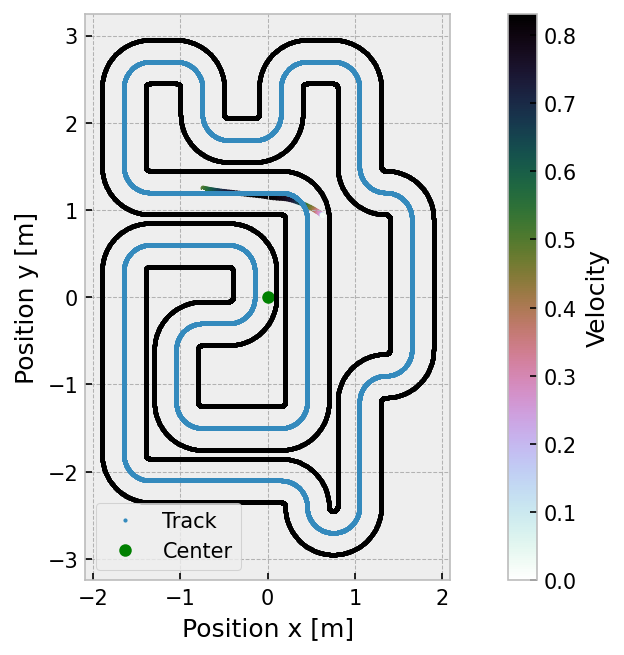

In [7]:
x_list = []
y_list = []

for i in range(x_simulated.shape[0]):
    xy = frenet_to_cartesian(x_simulated[i,0,:2], track_coord)
    x_list.append(xy[0].numpy())
    y_list.append(xy[1].numpy())

x_plot = np.array(x_list)
y_plot = np.array(y_list)

from matplotlib import cm


fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=150)
gen.plotPoints(ax)
#gen.pointAtArcLength(0)
#gen.writePointsToYaml('../tracks/' + track_name + '.yaml', track_density)

custom_cmap = plt.get_cmap('cubehelix').reversed()
sct = ax.scatter(x_plot, y_plot, c=x_simulated[:,0,3].detach(), cmap=custom_cmap, s=4)

cbar = plt.colorbar(sct)
cbar.set_label('Velocity') 

print('x_init: ' + str(gen.xCoords[0]))
print('y_init: ' + str(gen.yCoords[0]))
print('yaw_init: ' + str(gen.tangentAngle[0]))
print('Total Arc Length: ' + str(gen.arcLength[-1]/2))
plt.show()

In [8]:
from mpc import casadi_control
from importlib import reload
reload(casadi_control)

<module 'mpc.casadi_control' from '/home/alan/Desktop/Research/Code/race_application/mpc/casadi_control.py'>

In [9]:
mpc_T_test = mpc_T

control = casadi_control.CasadiControl(track_coord, params.numpy())

dc = 2 #number constraints
df = 2 #number of states we artificially added like sigma_0, sigma_diff
dx = n_state #number states taken from the dynamics (including penalties and sigma_o/sigma_diff)
du = n_ctrl #number control inputs

N_sim_total = 200
#x_simulated = torch.zeros((N_sim_total,1,10))

#x_simulated[0] = x_init_test[0]

x_execution = np.zeros((N_sim_total,1,8))
x_simulated = np.zeros((N_sim_total,1,8))

x_simulated[0] = x_init_exec_sim[[0,1,2,4,6,7,8,9]].numpy()
x_execution[0] = x_init_exec_sim[[0,1,2,4,6,7,8,9]].numpy()

q_penalty_batch = q_penalty.unsqueeze(0).repeat(N_test,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(N_test,1)

for i in range(1,N_sim_total):

    x_sim = x_simulated[i-1]
    print('It:', i, 'x=', x_sim.round(3))

    Q_test_batch, p_test_batch = inference_params(
        torch.tensor(x_sim).float(), track_coord, H_curve, model, 
        q_penalty_batch, p_penalty_batch, 
        N_test, mpc_T_test)
    
    test_q = torch.diag(Q_test_batch[0,0]).detach().numpy()
    test_p = p_test_batch[0,0].detach().numpy()
    
    #sigma, d, phi, r, v_x, v_y, sigma_0, sigma_diff, d_pen, v_ub 
    
    #test_q=np.array([0.,1.5,0.2,0.01,0.0,0.,0.,0.0,0.,0.,0.1,0.1])
    #test_p=np.array([0.,0.,0.,0.,-1.,0.,0.,-4.5,100.,100., 0., 0.])

    sol = control.mpc_casadi_with_constraints(
        test_q,test_p,x_sim,
        mpc_T_test,df,dc,dx,du)
    
    u_mpc_test = sol[-du*mpc_T_test:]
    x_mpc_test = sol[:-du*mpc_T_test]
    u_mpc_test = u_mpc_test.reshape(mpc_T_test,du)
    x_mpc_test = x_mpc_test.reshape(mpc_T_test+1,dx-dc-df)


    x_simulated[i,0,:4] = torch.tensor(x_mpc_test[1])
    x_simulated[i,0,4] = torch.tensor(x_simulated[i,0,0])
    x_simulated[i,0,5] = 0.

9
It: 1 x= [[ 0.01  0.05 -0.    0.5   0.01  0.    0.    0.  ]]
curv start
curv end
curv start
curv end
curv start
curv end

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables wi

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -9.0750297e-02 8.60e-01 4.05e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -2.1757588e-01 1.18e+00 3.91e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

   7 -3.5412851e+00 2.31e-04 8.00e-02  -3.8 2.21e+00    -  2.50e-01 9.52e-01h  1
   8 -3.5487208e+00 6.31e-05 3.89e-02  -3.8 1.10e+00    -  5.00e-01 1.00e+00h  1
   9 -3.5541833e+00 3.00e-04 6.35e-03  -3.8 2.04e+00    -  9.88e-01 8.02e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -3.5546528e+00 2.46e-05 5.18e-05  -3.8 4.18e-01    -  1.00e+00 1.00e+00f  1
  11 -3.5566186e+00 4.83e-06 3.09e-05  -5.7 4.17e-01    -  8.78e-01 8.84e-01h  1
  12 -3.5569630e+00 5.61e-07 5.03e-07  -5.7 1.30e-01    -  1.00e+00 1.00e+00h  1
  13 -3.5569916e+00 2.87e-09 5.40e-07  -8.6 8.72e-03    -  9.94e-01 9.99e-01h  1
  14 -3.5569916e+00 4.23e-13 5.78e-13  -8.6 6.11e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:  -3.5569916472699465e+00   -3.5569916472699465e+00
Dual infeasibility......:   5.7771842865150802e-13    5.7771842865150802e-13
Constraint viol

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -4.4951575e-01 9.40e-01 4.10e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -5.4999654e-01 9.40e-01 3.97e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -6.1441342e-01 9.40e-01 3.87e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -6.9348835e-01 9.91e-01 3.66e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.5804887e+00 1.06e+00 3.81e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.2262607e+00 1.06e+00 1.30e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1742587e+01 1.42e+00 1.49e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.3557424e+01 1.66e+00 1.49e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2104883e+01 1.90e+00 1.01e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.8405836e+00 2.04e+00 4.09e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -2.1578436e+00 2.14e+00 4.25e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -2.4666149e+00 2.22e+00 4.43e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

   3  3.5363081e+00 1.49e-01 1.32e+00  -1.0 1.92e+00    -  3.32e-01 7.23e-01f  1
   4  3.6221604e+00 4.56e-03 2.71e+00  -1.0 2.89e-01    -  3.61e-01 1.00e+00f  1
   5  2.3778602e+00 2.36e-03 1.42e+00  -1.0 5.33e-01    -  7.27e-01 5.30e-01f  1
   6  5.1719177e-01 1.61e-02 2.43e-01  -1.0 3.21e+00    -  1.00e+00 1.00e+00f  1
   7  4.1087063e-02 1.93e-03 5.00e-02  -1.7 5.78e-01    -  9.79e-01 9.21e-01f  1
   8 -5.7928192e-02 3.98e-04 1.69e-01  -2.5 4.00e-01    -  8.51e-01 1.00e+00f  1
   9 -9.2060098e-02 1.72e-04 9.92e-04  -2.5 3.47e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.0799186e-01 7.18e-05 1.23e-03  -3.8 2.37e-01    -  9.29e-01 9.35e-01h  1
  11 -1.1077962e-01 1.97e-05 5.64e-05  -3.8 1.01e-01    -  1.00e+00 1.00e+00f  1
  12 -1.1151620e-01 4.06e-06 3.26e-04  -5.7 3.56e-02    -  9.86e-01 9.97e-01h  1
  13 -1.1156360e-01 8.46e-08 1.53e-07  -5.7 2.47e-03    -  1.00e+00 1.00e+00f  1
  14 -1.1156997e-01 4.43e-10

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -3.0071822e+00 2.38e+00 5.63e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -3.2974662e+00 2.65e+00 5.36e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -3.5970092e+00 2.91e+00 4.96e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -3.9269907e+00 3.18e+00 4.63e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.7519839e+01 3.45e+00 1.28e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.2694672e+01 3.64e+00 1.48e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.3430875e+01 3.86e+00 1.01e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -5.3719412e+00 4.16e+00 4.48e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -5.6558993e+00 4.43e+00 4.44e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -5.7711026e+00 4.68e+00 4.19e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.0329590e+01 4.83e+00 1.33e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2826984e+02 4.95e+00 1.49e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.3460478e+02 5.05e+00 1.49e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.4015379e+02 5.14e+00 1.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.3526373e+02 5.20e+00 1.24e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1261069e+02 5.25e+00 7.69e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.6722709e+01 5.28e+00 4.74e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.9626290e+01 5.30e+00 3.57e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.9168243e+01 5.30e+00 3.83e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7159139e+01 5.29e+00 3.61e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.2219011e+01 5.28e+00 4.91e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1961916e+01 5.28e+00 4.91e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1906948e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1877578e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1869225e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1866782e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1866103e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865895e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865847e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865819e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865823e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865810e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865823e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865823e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865823e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865823e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865823e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865823e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865823e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865823e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865823e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865823e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865823e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865823e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865823e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865823e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865823e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865823e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865823e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865823e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865823e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865823e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865823e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865823e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865823e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      304
Number of nonzeros in inequality constraint Jacobian.:       62
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:       94
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1865823e+01 5.28e+00 4.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

x_init: -0.7499999999999999
y_init: 1.1999999999999995
yaw_init: 0.0
Total Arc Length: 26.8655890901819


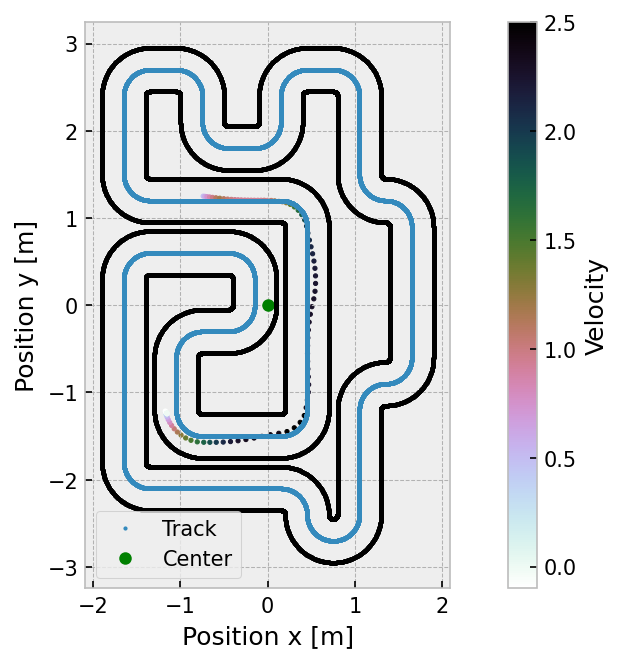

In [10]:
x_list = []
y_list = []

for i in range(x_simulated.shape[0]):
    xy = frenet_to_cartesian(x_simulated[i,0,:2], track_coord)
    x_list.append(xy[0].numpy())
    y_list.append(xy[1].numpy())

x_plot = np.array(x_list)
y_plot = np.array(y_list)

from matplotlib import cm


fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=150)
gen.plotPoints(ax)
#gen.pointAtArcLength(0)
#gen.writePointsToYaml('../tracks/' + track_name + '.yaml', track_density)

custom_cmap = plt.get_cmap('cubehelix').reversed()
sct = ax.scatter(x_plot, y_plot, c=x_simulated[:,0,3], cmap=custom_cmap, s=4)

cbar = plt.colorbar(sct)
cbar.set_label('Velocity') 
#ax.plot(x_plot, y_plot)

#ax.scatter(x_plot[23:25], y_plot[23:25], color='red', s=4)

#ax.scatter(x_plot, y_plot, s=4, color='red')

print('x_init: ' + str(gen.xCoords[0]))
print('y_init: ' + str(gen.yCoords[0]))
print('yaw_init: ' + str(gen.tangentAngle[0]))
print('Total Arc Length: ' + str(gen.arcLength[-1]/2))
plt.show()